In [20]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [21]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import random
random.seed(1987)

case grids:
```bash
/data100t1/home/wanying/BioVU/202505_hypophosphatasia/data/hpp_icd_code_counts_in_sd.case_only.csv
```

SD demographic:
```bash
/data100t1/share/synthetic-deriv/demographic-releases/2025-mar-19/sd_demographics.csv.gz
```

In [2]:
case_path = Path('/data100t1/home/wanying/BioVU/202505_hypophosphatasia/data/hpp_icd_code_counts_in_sd.case_only.csv')
sd_demo_path = Path('/data100t1/share/synthetic-deriv/demographic-releases/2025-mar-19/sd_demographics.csv.gz')
sd_phecode_path = Path('/data100t1/share/synthetic-deriv/phecodes/all-sd-phecodes-mar-2025/all-sd-codes.csv.gz')
depth_of_record_path = Path('/data100t1/home/wanying/BioVU/202505_hypophosphatasia/data/depth_of_record_in_sd.csv')

case_df = pd.read_csv(case_path)
sd_demo_df = pd.read_csv(sd_demo_path)
# sd_phecode_df = pd.read_csv(sd_phecode_path)
depth_df = pd.read_csv(depth_of_record_path)

display(case_df.shape)
display(case_df.head())

display(sd_demo_df.shape)
display(sd_demo_df.head())

# display(sd_phecode_df.head())

display(depth_df.shape)
display(depth_df.head())

(21091, 2)

,grid,count_hpp_icd_code
0,R299892612,1
1,R299896297,1
2,R299896894,1
3,R299903282,1
4,R299904906,1


(3965634, 5)

,grid,birth_datetime,gender_source_value,ethnicity_source_value,race_source_value
0,R200000048,2002-03-29T00:00:00.000-06:00,F,NH,B
1,R200000050,1950-08-27T00:00:00.000-05:00,F,NH,U
2,R200000069,1970-07-13T00:00:00.000-05:00,F,NT,W
3,R200000084,1937-06-18T00:00:00.000-05:00,F,NT,W
4,R200000141,1999-07-14T00:00:00.000-05:00,M,UN,U


(3560216, 2)

,grid,depth_of_record
0,R200000048,17
1,R200000069,113
2,R200000084,71
3,R200000141,2
4,R200000176,2


In [3]:
case_df_2 = case_df[case_df.count_hpp_icd_code>1]
case_df_2.shape

(9476, 2)

In [4]:
def find_match_controls(case_of_interest, cases_df, controls_df):
    '''
    Find matching controls for the cases
    SEX, RACE, ETH matched
    AGE: +/- 5 year-old
    VISIT_COUNT: +/- 5 visits
    '''
    case = cases_df[cases_df.grid==case_of_interest]
    sex = case.gender_source_value.iloc[0]
    age_in_days = case.age_in_days.iloc[0]
    eth = case.ethnicity_source_value.iloc[0]
    race = case.race_source_value.iloc[0]
    depth_of_record = case.depth_of_record.iloc[0]

    mask = ((controls_df.gender_source_value == sex) &
            (controls_df.race_source_value == race) &
            (controls_df.ethnicity_source_value == eth) &
            (controls_df.age_in_days < age_in_days + 365 * 5) &
            (controls_df.age_in_days > age_in_days - 365 * 5) &
            (controls_df.depth_of_record < depth_of_record + 5) &
            (controls_df.depth_of_record > depth_of_record - 5)
           )
    controls_matched = list(controls_df[mask].grid)
    return controls_matched, controls_df[mask]


In [3]:
sd_info_df = sd_demo_df.merge(depth_df, on='grid')

sd_info_df['birthday'] = pd.to_datetime(sd_info_df['birth_datetime'], utc=True)
now = pd.Timestamp.now(tz='UTC')
sd_info_df['age_in_days'] = (now - sd_info_df['birthday']).dt.days

case_with_info_df = sd_info_df[sd_info_df.grid.isin(case_df.grid)]
control_with_info_df = sd_info_df[~sd_info_df.grid.isin(case_df.grid)]

In [4]:
case_with_info_df.to_csv('../data/hpp_case_sd.csv', sep='\t', index=False)
control_with_info_df.to_csv('../data/hpp_contrl_sd.csv', sep='\t', index=False)

In [11]:
found_controls = set()
header = ['case'] + [f'Control{i}' for i in range(1, 11)]
fh = open('../results/case_control_pairs1.txt', 'w')
fh.write('\t'.join(header))
fh.write('\n')
for case in tqdm(case_with_info_df.grid):
    # control_with_info_updated_df = control_with_info_df[~control_with_info_df.grid.isin(found_controls)]
    potential_matches, _ = find_match_controls(case, case_with_info_df, control_with_info_df)
    exclusive_matches = [x for x in potential_matches if x not in found_controls]
    random.shuffle(exclusive_matches)
    exclusive_matches_10 = exclusive_matches[:10]
    found_controls.update(exclusive_matches_10)
    line = '\t'.join([case] + exclusive_matches_10) + '\n'
    fh.write(line)
fh.close()

  0%|          | 5/21091 [00:09<11:38:51,  1.99s/it]


KeyboardInterrupt: 

## Check matched controls

In [7]:
case_control_pairs = pd.read_csv('../results/case_control_pairs_2.txt', sep='\t')
case_control_pairs.head()

,case,Control1,Control2,Control3,Control4,Control5,Control6,Control7,Control8,Control9,Control10
0,R200010051,R213989509,R200107575,R213398961,R207553207,R254866702,R221213724,R261029483,R286938215,R243194053,R212272945
1,R200023025,R252492152,R270367319,R200323505,R264042088,R248765867,R214106976,R253647889,R207157292,R284846796,R267339172
2,R200026593,R268609817,R245823262,R261072421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R200044004,R204842285,R245974475,R221726981,R294059776,R242125874,R273818435,R288281082,R283840951,R268524004,R207660380
4,R200050438,R232354006,R282338236,R216786298,R210245677,R281065140,R236580875,R280911941,R292340834,R290241605,R246670801


In [8]:
case_control_pairs.shape, case_control_pairs.dropna().shape

((9476, 11), (7294, 11))

In [9]:
number_of_missing = case_control_pairs.isna().sum()

In [11]:
number_of_missing.sum()

16074

In [13]:
number_of_missing

case            0
Control1      687
Control2     1012
Control3     1272
Control4     1495
Control5     1641
Control6     1784
Control7     1900
Control8     2005
Control9     2096
Control10    2182
dtype: int64

In [12]:
94760-16074

78686

In [6]:
case_control_pairs.iloc[:,:2].dropna().shape

(19699, 2)

In [7]:
np.random.choice([],1)

ValueError: 'a' cannot be empty unless no samples are taken

In [1]:
d = {'a':1, 'b':2}

In [3]:
list(d.keys())

['a', 'b']

## Generate statistics

In [25]:
results = pd.read_csv('../results/icd_count_2.frequencies_and_pval.txt', sep='\t', dtype={'phecode':str})
results_sig = results[results.pval<1e-5]

In [29]:
results_sig.head()

,phecode,pval,case_freq,control_freq_1,control_freq_2,control_freq_3,control_freq_4,control_freq_5,control_freq_6,control_freq_7,...,control_freq_991,control_freq_992,control_freq_993,control_freq_994,control_freq_995,control_freq_996,control_freq_997,control_freq_998,control_freq_999,control_freq_1000
0,008,0.0,1343,692,724,689,686,643,711,692,...,719,704,736,718,701,686,719,678,714,725
1,008.5,0.0,792,257,269,258,261,242,281,258,...,275,280,266,296,290,271,285,254,275,266
2,008.51,0.0,46,7,7,6,5,7,4,10,...,7,5,8,8,13,5,9,4,7,7
3,008.52,0.0,653,189,207,197,204,180,213,192,...,195,209,198,208,203,202,215,187,220,187
4,008.6,0.0,600,320,343,331,314,321,325,332,...,337,332,355,339,324,314,344,315,333,329


In [20]:
results.shape, results_sig.shape

((1877, 1003), (841, 1003))

In [29]:
840/1877

0.447522642514651

In [44]:
enriched_phecodes = pd.read_csv('../results/hpp_icd_count_2_enriched_phecode.csv', sep='\t', dtype={'Phecode':str})

In [4]:
enriched_phecodes.shape

(840, 13)

In [17]:
enriched_phecodes[enriched_phecodes.Count>90].shape

(754, 13)

In [22]:
enriched_phecodes = enriched_phecodes[enriched_phecodes.Count>90]
enriched_phecodes.to_csv('../results/hpp_icd_count_2_enriched_phecode_updated.csv', sep='\t')

In [16]:
(9476-687)*.01

87.89

In [45]:
enriched_phecodes.dtypes

Phecode                   object
Description               object
Count                      int64
p.value                  float64
p01                        int64
p05                        int64
p10                        int64
p50                        int64
p90                        int64
p95                        int64
p99                        int64
max                        int64
case_to_control_ratio    float64
dtype: object

In [46]:
enriched_phecodes[enriched_phecodes.Phecode=='588']

,Phecode,Description,Count,p.value,p01,p05,p10,p50,p90,p95,p99,max,case_to_control_ratio
9,588,Disorders resulting from impaired renal function,2719,0.0,351,360,366,385,407,412,427,433,6.28


In [23]:
def plot_freq_dist(results: pd.DataFrame, folder: str, count: bool = False, N: int = 1762) -> None:
    """
    Plot frequency distributions for each phecode in the results DataFrame.
    
    Args:
        results (pd.DataFrame): DataFrame containing phecode results with case and control frequencies
        folder (str): Output folder path to save plots
        count (bool): If True, normalize frequencies by dividing by N
        N (int): Total number of samples for normalization if count=True
        
    Returns:
        None: Creates and saves plots to specified folder
    """
    for i in tqdm(range(len(results))):
        # Extract control frequencies from columns 3 to second-to-last
        control_freq = np.array(list(results.iloc[i, 3:-1]))
        case_freq = results.loc[i, 'case_freq']

        # Normalize frequencies if count=True
        if count:
            control_freq = control_freq / N
            case_freq = case_freq / N
        
        # Create distribution plot
        sns.displot(data=control_freq, kde=True, height=5, aspect=1.5)
        plt.axvline(case_freq, c='r', linewidth=5)
        
        # Get metadata for plot title
        code, pval, desc = results.loc[i, 'phecode'], results.loc[i, 'pval'], results.loc[i, 'PhecodeString']
        plt.title(f"Phecode: {code}; Description: {desc}; pval: {pval}")
        
        # Save and close plot
        plt.savefig(f'{folder}/phecode_{code}.png', bbox_inches='tight')
        plt.close()

In [33]:
results_selected = results[results.phecode=='588']
results_selected

,phecode,pval,case_freq,control_freq_1,control_freq_2,control_freq_3,control_freq_4,control_freq_5,control_freq_6,control_freq_7,...,control_freq_991,control_freq_992,control_freq_993,control_freq_994,control_freq_995,control_freq_996,control_freq_997,control_freq_998,control_freq_999,control_freq_1000
1208,588,0.0,2719,361,416,390,381,379,398,405,...,396,409,347,392,371,376,374,367,378,409


In [34]:
9476-687

8789

Text(0.5, 1.0, 'Phecode: 588; Description: Disorders resulting from impaired renal function; pval: 0.0')

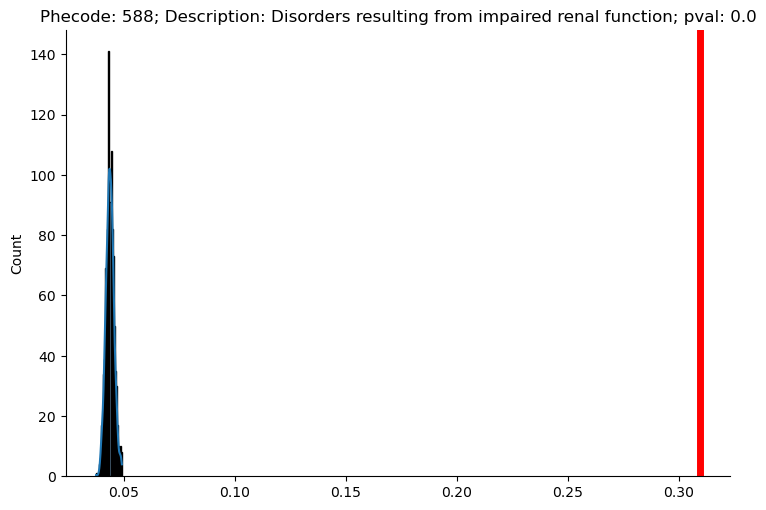

In [47]:
def plot_phecode_dist(phecode, results_df, N=8789):
    """
    Plot distribution of control frequencies for a given phecode.
    
    Args:
        phecode (str): Phecode to plot
        results_df (pd.DataFrame): DataFrame containing results
        N (int): Total number of controls for normalization
        
    Returns:
        None: Creates and displays plot
    """
    # Find row index for given phecode
    i = results_df[results_df.phecode == phecode].index[0]
    
    # Get frequencies
    control_freq = np.array(list(results_df.iloc[i, 3:-1]))
    case_freq = results_df.loc[i, 'case_freq']
    
    # Normalize frequencies
    control_freq = control_freq / N
    case_freq = case_freq / N
    
    # Create plot
    sns.displot(data=control_freq, kde=True, height=5, aspect=1.5)
    plt.axvline(case_freq, c='r', linewidth=5)
    
    # Get metadata
    code = results_df.loc[i, 'phecode']
    pval = results_df.loc[i, 'pval']
    desc = results_df.loc[i, 'PhecodeString']
    
    plt.title(f"Phecode: {code}; Description: {desc}; pval: {pval}")